In [1]:
import re
import csv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import statistics
import os

def episode(s, e, name, path):
    if e < 10:
        stt = name +str(s)+'E0'+str(e) 
    else:
        stt = name +str(s)+'E'+str(e) 
    #print(stt)
    edic = {}
    files = os.listdir(path)
    for f in files:
        if f.startswith(stt):
            #en = int(f[11:14])
            en = int(f.split('.')[0].split('_')[-1])
            #print(f, en)
            edic[en] = f
    return edic
 
def readG(f, path):
    #print(f)
    return nx.read_graphml( path + f)

def histogram(G):
    hist = {}
    dict = {}
    for node in G.nodes(data=True):
        dict[node[0]] = node[1]['label']
        
    #print(dict)
    for edge in G.edges(data=True):
        for i in range(2):
            node = dict[edge[i]]
            #print(node)
            try:
                hist[node] += 1
            except:
                hist[node] = 1
    return hist
    
def node_dict(g):
    dict = {}
    for node in g.nodes(data=True):
        dict[node[0]] = node[1]['label']
    return dict
    
def get_corr_pearson(review):
    dict = {'Network Metrics':[],
            'Correlation':[],
            'pValue':[]
           }

    for col in ['Act_Nodes','Wgt_Density','Max_Degree','Var_Degree','Std_Degree',\
               'Max_Betweeness','Var_Betweeness','Std_Betweeness','Max_Eigen','Var_Eigen','Std_Eigen']:
        corr, pval = pearsonr(review[col], review['Review'])
        dict['Network Metrics'].append(col)
        dict['Correlation'].append(corr)
        dict['pValue'].append(pval)

    df_corr = pd.DataFrame(dict)
    return df_corr


def get_corr_spearman(review):
    dict = {'Network Metrics':[],
            'Correlation':[],
            'pValue':[]
           }
 
    for col in ['Act_Nodes','Wgt_Density','Max_Degree','Var_Degree','Std_Degree',\
                'Max_Betweeness','Var_Betweeness','Std_Betweeness','Max_Eigen','Var_Eigen','Std_Eigen']:
        corr, pval = spearmanr(review[col], review['Review'])
        dict['Network Metrics'].append(col)
        dict['Correlation'].append(corr)
        dict['pValue'].append(pval)

    df_corr = pd.DataFrame(dict)
    return df_corr
        
def nx_aggregate_graph(s, e, name, path ):
    edic = episode(s,e,name, path)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
    
    degrees = []
    count = len(sorted_x)
    act_nodes = set()
    
    newg = {}
    for k, v in sorted_x:
        g = readG(v, path)
    
        nd = node_dict(g)
        for node1, node2, data in g.edges(data=True):
            node1  = nd[node1]
            node2  = nd[node2]
            weight = data['weight']
            try:
                newg[(node1, node2)] += weight
            except:
                newg[(node1, node2)]  = weight
                
    nxG = nx.Graph() 
    for k in newg:         
        nxG.add_edge(k[0], k[1], weight = newg[k] / count)
            
    return nxG

def max_variance_stdev(dictData):
    data = []
    for k in dictData:
        data.append(dictData[k])
     
    return max(data), statistics.variance(data), statistics.stdev(data)
    
def max_variance_stdev2(pairData):
    data = []
    for k in pairData:
        data.append(k[1])
     
    return max(data), statistics.variance(data), statistics.stdev(data)

def graph_statistics(s, e, name, path):
    nxG = nx_aggregate_graph(s, e, name, path)
    cnt_nodes = nxG.number_of_nodes()
   
    sum_weight = 0
 
    for k in nxG.edges.data():
        sum_weight += k[2]['weight']
    
    max_dgr, var_dgr, std_dgr = max_variance_stdev2(nxG.degree())
    max_bet, var_bet, std_bet = max_variance_stdev(nx.betweenness_centrality(nxG))
    max_eig, var_eig, std_eig = max_variance_stdev(nx.eigenvector_centrality_numpy(nxG, weight = 'weight')) 
    
    glb_efficiency =  nx.global_efficiency(nxG)
    transitivity = nx.transitivity(nxG)
    components = nx.number_connected_components(nxG)
 
    return cnt_nodes, sum_weight * 2/cnt_nodes/(cnt_nodes-1), max_dgr, var_dgr, std_dgr, max_bet, var_bet, std_bet, max_eig, var_eig, std_eig


def get_df(review , path, name, lastS = 4, lastE = 11, size = 22):
    weighted_dens = []
    num_actnodes = []
    
    max_dgr_list = []
    var_dgr_list = []
    std_dgr_list = []
    
    max_bet_list = []
    var_bet_list = []
    std_bet_list = []
    
    max_eig_list = []
    var_eig_list = []
    std_eig_list = []
    
    files = os.listdir(path)
    for S in range(1,lastS):
        for E in range(1,lastE):
            if review == 'GoT.csv':
                if S == 3 and E > 2:
                    break
            try:
                cnt_nodes, density, max_dgr, var_dgr, std_dgr, max_bet, var_bet, std_bet, \
                max_eig, var_eig, std_eig = graph_statistics(S, E,  name, path)
            
                num_actnodes.append(cnt_nodes)
                weighted_dens.append(density)
            
                max_dgr_list.append(max_dgr)
                var_dgr_list.append(var_dgr)
                std_dgr_list.append(std_dgr)
                
                max_bet_list.append(max_bet)
                var_bet_list.append(var_bet)
                std_bet_list.append(std_bet)
                
                max_eig_list.append(max_eig)
                var_eig_list.append(var_eig)
                std_eig_list.append(std_eig)
                
            except:
                #print(S,E)
                pass

    
    GoT_review = pd.read_csv(review).drop(columns='Unnamed: 0')  
    review = GoT_review.head(size)
    
    review2 = review.assign(Act_Nodes   = num_actnodes)
    review2 = review2.assign(Wgt_Density = weighted_dens)
    
    review2 = review2.assign(Max_Degree  = max_dgr_list)
    review2 = review2.assign(Var_Degree = var_dgr_list)
    review2 = review2.assign(Std_Degree = std_dgr_list)

    review2 = review2.assign( Max_Betweeness = max_bet_list)
    review2 = review2.assign(Var_Betweeness = var_bet_list)
    review2 = review2.assign(Std_Betweeness = std_bet_list)
    
    review2 = review2.assign( Max_Eigen  = max_eig_list)
    review2 = review2.assign(Var_Eigen = var_eig_list)
    review2 = review2.assign(Std_Eigen = std_eig_list)
    
    return review2

#df = get_df()
#df

# Game of Throne

In [2]:
import pandas as pd
files = os.listdir("Data/GoT_dyn_ts10/")
df_GoT = get_df('GoT.csv',   "Data/GoT_dyn_ts10/",   'GoT_S0', 4, 11,22)
df_GoT

,Episode,Review,Act_Nodes,Wgt_Density,Max_Degree,Var_Degree,Std_Degree,Max_Betweeness,Var_Betweeness,Std_Betweeness,Max_Eigen,Var_Eigen,Std_Eigen
0,Winter Is Coming,9.001235,30,0.690040,10,6.298851,2.509751,0.136951,0.001118,0.033437,0.627124,0.024644,0.156983
1,The Kingsroad,8.701235,27,1.083208,10,5.256410,2.292686,0.206827,0.002836,0.053255,0.651149,0.028562,0.169003
2,Lord Snow,8.601235,46,0.558816,14,7.087923,2.662315,0.136869,0.000609,0.024672,0.599716,0.018400,0.135645
3,"Cripples, Bastards, and Broken Things",8.701235,48,0.510097,12,5.822695,2.413026,0.127660,0.000671,0.025895,0.693070,0.019660,0.140215
4,The Wolf and the Lion,9.001235,40,0.816745,12,4.964103,2.228027,0.402834,0.007308,0.085487,0.612491,0.021352,0.146123
5,A Golden Crown,9.101235,42,0.808435,13,4.422764,2.103037,0.300610,0.003949,0.062840,0.702449,0.022304,0.149344
6,You Win or You Die,9.201235,38,0.832231,10,2.677098,1.636184,0.072072,0.000141,0.011861,0.605566,0.022960,0.151526
7,The Pointy End,9.001235,53,0.312144,8,3.554427,1.885319,0.051911,0.000115,0.010732,0.701746,0.018117,0.134599
8,Baelor,9.601235,50,0.553801,8,3.422041,1.849876,0.050170,0.000085,0.009206,0.704289,0.018864,0.137345
9,Fire and Blood,9.501235,49,0.374416,9,3.083333,1.755942,0.092051,0.000360,0.018981,0.707107,0.019625,0.140091


In [3]:
get_corr_pearson(df_GoT)

,Network Metrics,Correlation,pValue
0,Act_Nodes,-0.400721,0.064579
1,Wgt_Density,0.108296,0.631428
2,Max_Degree,-0.078416,0.728691
3,Var_Degree,0.007646,0.973062
4,Std_Degree,0.028401,0.900159
5,Max_Betweeness,0.039684,0.860813
6,Var_Betweeness,0.084570,0.708266
7,Std_Betweeness,0.076634,0.734636
8,Max_Eigen,0.235836,0.290697
9,Var_Eigen,0.455370,0.033203


In [4]:
get_corr_spearman(df_GoT)

,Network Metrics,Correlation,pValue
0,Act_Nodes,-0.489992,0.020618
1,Wgt_Density,0.254436,0.253172
2,Max_Degree,0.053462,0.813206
3,Var_Degree,0.088650,0.694832
4,Std_Degree,0.088650,0.694832
5,Max_Betweeness,0.133550,0.553513
6,Var_Betweeness,0.189388,0.398595
7,Std_Betweeness,0.189388,0.398595
8,Max_Eigen,0.236015,0.290319
9,Var_Eigen,0.560680,0.006640


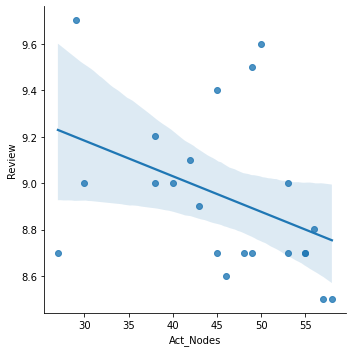

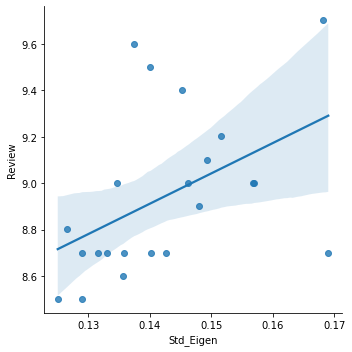

In [5]:
import seaborn as sns
ax = sns.lmplot(x='Act_Nodes', y="Review", data=df_GoT);
ax = sns.lmplot(x='Std_Eigen', y="Review", data=df_GoT);

# House of Cards

In [6]:
files = os.listdir("Data/HoC_dyn_ts10")
df_hoc = get_df('HoC.csv', "Data/HoC_dyn_ts10/",  'HoC_S0', 3, 14, 26)
df_hoc

,Episode,Review,Act_Nodes,Wgt_Density,Max_Degree,Var_Degree,Std_Degree,Max_Betweeness,Var_Betweeness,Std_Betweeness,Max_Eigen,Var_Eigen,Std_Eigen
0,Chapter 1,8.601235,30,0.785183,17,9.678161,3.110974,0.865764,0.028376,0.168451,0.690839,0.024348,0.156039
1,Chapter 2,8.501235,33,0.662256,19,10.371212,3.220437,0.890121,0.026036,0.161356,0.681986,0.020150,0.141952
2,Chapter 3,8.301235,33,0.719754,22,13.689394,3.699918,0.811492,0.021531,0.146733,0.668723,0.020824,0.144304
3,Chapter 4,8.201235,31,0.756132,17,9.255914,3.042353,0.774713,0.022470,0.149901,0.676685,0.021479,0.146558
4,Chapter 5,8.401235,36,0.547713,20,12.863492,3.586571,0.716078,0.017811,0.133460,0.674420,0.020957,0.144766
5,Chapter 6,8.501235,33,0.711649,19,11.047348,3.323755,0.830645,0.023263,0.152523,0.672901,0.022361,0.149537
6,Chapter 7,8.101235,34,0.725868,18,10.452763,3.233073,0.753157,0.019128,0.138305,0.605957,0.019832,0.140825
7,Chapter 8,7.701235,19,1.995190,8,3.116959,1.765491,0.166667,0.001562,0.039526,0.706311,0.045252,0.212724
8,Chapter 9,8.501235,23,1.725946,12,11.019763,3.319603,0.414863,0.013359,0.115583,0.658181,0.027017,0.164368
9,Chapter 10,8.701235,21,1.654808,14,9.328571,3.054271,0.689474,0.025277,0.158986,0.562667,0.024211,0.155598


In [7]:
get_corr_pearson(df_hoc)

,Network Metrics,Correlation,pValue
0,Act_Nodes,-0.158587,0.439059
1,Wgt_Density,0.128514,0.531532
2,Max_Degree,-0.339142,0.090096
3,Var_Degree,-0.290424,0.150070
4,Std_Degree,-0.257928,0.203319
5,Max_Betweeness,0.252256,0.213786
6,Var_Betweeness,0.418447,0.033382
7,Std_Betweeness,0.467669,0.015990
8,Max_Eigen,-0.105222,0.608955
9,Var_Eigen,-0.035369,0.863805


In [8]:
get_corr_spearman(df_hoc)

,Network Metrics,Correlation,pValue
0,Act_Nodes,-0.352659,0.077219
1,Wgt_Density,0.417801,0.033683
2,Max_Degree,-0.493139,0.010473
3,Var_Degree,-0.408149,0.038459
4,Std_Degree,-0.408149,0.038459
5,Max_Betweeness,0.032404,0.875133
6,Var_Betweeness,0.315419,0.116507
7,Std_Betweeness,0.315419,0.116507
8,Max_Eigen,0.030335,0.883048
9,Var_Eigen,0.498811,0.009490


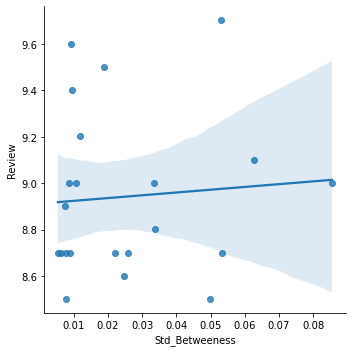

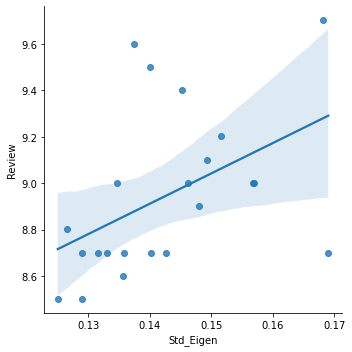

In [9]:
import seaborn as sns
ax = sns.lmplot(x='Std_Betweeness', y="Review", data=df_GoT);
ax = sns.lmplot(x='Std_Eigen', y="Review", data=df_GoT);

# Breaking Bad

In [ ]:
files = os.listdir("Data/BB_dyn_ts10")
df_bb = get_df('BB.csv', "Data/BB_dyn_ts10/",  'BB_S0', 4, 14, 26)
df_bb

In [ ]:
get_corr_pearson(df_bb)

In [ ]:
get_corr_spearman(df_bb)

# Graph Overview

In [ ]:
def describe(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e,name, path)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
 
    for k, v in sorted_x:
        g = readG(v, path)
    
        nd = node_dict(g)
        
        nodes = set()
        for node1, node2, data in g.edges(data=True):
            nodes.add(node1)
            nodes.add(node2)
            
        print(int(v.split('.')[0].split('_')[-1]),',', len(nodes), ',',len(g.edges))
            
def describe_df(review = 'GoT.csv', path = "Data/GoT_dyn_ts10/", name = 'GoT_S0', lastS = 4, lastE = 11, size = 22):
    files = os.listdir(path)
    for S in range(1,lastS):
        for E in range(1,lastE):
            if review == 'GoT.csv':
                if S == 3 and E > 2:
                    break
            try:
                describe(S, E,  name, path)
                 
            except:
                print(S,E)
                pass
            
describe(1, 1)

In [ ]:
import pyvis
from pyvis.network import Network

def print_graph(g):
    for node1, node2, data in g.edges(data=True):
        print(node1, node2, data)
        
def create_new_graph(g, d):
    #g.remove_nodes_from(list(nx.isolates(g)))
    ng = Network("800px","800px", notebook = True)
    #ng.options.set_tree_spacing(10)
    nset = set()
    for node1, node2, data in g.edges(data=True):
        #print(node1, node2, data)
        nset.add(node1)
        nset.add(node2)
        
    for n in nset:
        ng.add_node(d[n])
        
    for node1, node2, data in g.edges(data=True):
        ng.add_edge(d[node1],d[node2], value = data["weight"], title = str(data["weight"]))    
        
    return ng


G = readG("GoT_S01E01_012.graphml", 'Data/GoT_dyn_ts10/')

ng = create_new_graph(G, node_dict(G))
#ng.options.Layout.set_tree_spacing(10)
 
ng.show("test.html")
 

In [ ]:
G = readG("GoT_S01E01_030.graphml", 'Data/GoT_dyn_ts10/')
ng = create_new_graph(G, node_dict(G))
ng.show("test.html")

In [ ]:
GoT_review = pd.read_csv("GoT.csv").drop(columns = 'Unnamed: 0')  
GoT_review

In [ ]:
df = GoT_review[["Episode", "Review"]]
ind = df.set_index("Episode", inplace = True)
bar = df.plot(kind='bar',figsize=(30, 16), color = "blue", legend = None)
#bar
plt.yticks(fontsize = 24)
plt.xticks(ind,fontsize = 18)
plt.xlabel("Episode", fontsize = 20)
plt.ylabel("Review", fontsize = 20)
plt.ylim(ymin=8)
plt.title("IMDB Review for Game of Throne", fontsize = 30)
bar.spines['top'].set_visible(False)
bar.spines['right'].set_visible(False)
bar.spines['bottom'].set_linewidth(0.5)
bar.spines['left'].set_visible(True)
plt.show()

# Stength over time

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def sort_dict_by_value(d, reverse = True):
  return dict(sorted(d.items(), key = lambda x: x[1], reverse = reverse))

def extract_ts(total_strength, ts_strength):
    total_strength = sort_dict_by_value(total_strength)
    #print(total_strength)
  
    first_5_strength = list(total_strength.items())[:5]
    #print(first_3_strength)
    
    strength_series = []
    for i in range(5):
        p_ts = []
        n = first_5_strength[i][0]
        for d in ts_strength:
            try:
                p_ts.append(d[n])
            except:
                p_ts.append(0)
        #print(p_ts, len(p_ts), sum(p_ts))
        strength_series.append(p_ts)
        
    df_ts = pd.DataFrame(
    { first_5_strength[0][0]: strength_series[0], 
      first_5_strength[1][0]: strength_series[1], 
      first_5_strength[2][0]: strength_series[2],
      first_5_strength[3][0]: strength_series[3],
      first_5_strength[4][0]: strength_series[4],})
    
    df_ts.insert(0, 'Scene', range(10, 10+ len(df_ts)*10, 10))
    return df_ts


def plot_ts(df, title, xtitle, ytitle,legendtitle):  
    # Create figure
    fig = go.Figure()

    cols = []
    for col in df.columns:
        if (col != 'Scene'):
            cols.append(col)
    
    # Loop df columns and plot columns to the figure
    for col_name in cols:
        fig.add_trace(go.Scatter(x=df['Scene'], y=df[col_name],
                            mode='lines', # 'lines' or 'markers'
                            name=col_name))

    fig.update_layout(
        title={
            'text': title,
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title=xtitle,
        yaxis_title=ytitle,
        legend_title=legendtitle,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
 
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="RebeccaPurple"
        )
    )
    
    fig.show()
    
    
def plot_ts2(df, title, xtitle ):  
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Scatter(x=df['Scene'], y=df['Nodes'],
                            mode='lines', # 'lines' or 'markers'
                            name='Nodes'), secondary_y=False)

    fig.add_trace(go.Scatter(x=df['Scene'], y=df['Density'],
                            mode='lines', # 'lines' or 'markers'
                            name='Density'), secondary_y=True)
    

    # Add figure title
    fig.update_layout(
        title={
            'text': title,
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    # Set x-axis title
    fig.update_xaxes(title_text=xtitle)

    # Set y-axes titles
    fig.update_yaxes(title_text="Nodes", secondary_y=False)
    fig.update_yaxes(title_text="Density", secondary_y=True)


    fig.show()
    
    
def get_strength_degree(s, e, name, path):
    edic = episode(s,e,name, path)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
  
    ts_strength = []
    ts_degree   = []
    nodes = set()
 
    for _, v in sorted_x:
 
        g = readG(v, path)
        d = node_dict(g)

        strength_dic = {}
        degree_dic = {}
        nd = node_dict(g)
        
        for node1, node2, data in g.edges(data=True):
            n1= nd[node1]
            n2= nd[node2]
            nodes.add(n1)
            nodes.add(n2)
            v = data['weight']
            
            try: 
                strength_dic[n1] += v
            except:
                strength_dic[n1] = v
                
            try: 
                strength_dic[n2] += v
            except:
                strength_dic[n2] = v
            
            try:
                degree_dic[n1] += 1
            except:
                degree_dic[n1] = 1
            
            try:
                degree_dic[n2] += 1
            except:
                degree_dic[n2] = 1
            
        
        ts_strength.append(strength_dic)
        ts_degree.append(degree_dic)
        #break
    
 
    #print(ts_strength)
    #print(ts_degree)
    
    total_strength = {}
    total_degree = {}
    
    for d in ts_strength:
        for k in d:
            try:
                total_strength[k] += d[k]
            except:
                total_strength[k]  = d[k]
    
    total_strength = sort_dict_by_value(total_strength)
    #print(total_strength)
    
    for d in ts_degree:
        for k in d:
            try:
                total_degree[k] += d[k]
            except:
                total_degree[k]  = d[k]
    #print(total_degree)

    strength_series  = extract_ts(total_strength, ts_strength)
    degree_series  = extract_ts(total_degree, ts_degree)
    return  strength_series, degree_series
 
def get_ts_activenodes(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e,name, path)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
    
    ts_act_nodes = []
    ts_act_density = []
 
    nodes = set()
 
    for _, v in sorted_x:
        g = readG(v, path)
        d = node_dict(g)
        
        num_nodes = g.number_of_nodes()
        ts_act_nodes.append(num_nodes)
        
        sum_weight = 0
        for _, _, data in g.edges(data=True):
            v = data['weight']
            sum_weight += v
            
        sum_edges  = len(g.edges)
        density = 2 * sum_edges / num_nodes / (num_nodes - 1)
 
        ts_act_density.append(density)
    
    df_ts = pd.DataFrame(
    { 'Nodes': ts_act_nodes, 
      'Density': ts_act_density })
    
    df_ts.insert(0, 'Scene', range(10,  10+len(df_ts)*10, 10))
        
    return df_ts
    
    
    
strength_series, degree_series = get_strength_degree(1,1,  'GoT_S0' , "Data/GoT_dyn_ts10/"   )
 
plot_ts(strength_series, 'Graph Strength Time Series', 'Scene', 'Strength', 'Character')
plot_ts(degree_series, 'Graph Degree Time Sereies', 'Scene', 'Degree', 'Character')

active_node_series = get_ts_activenodes(1,1, 'GoT_S0' , "Data/GoT_dyn_ts10/" )
 
plot_ts2(active_node_series, 'Episode 1 Network Nodes and Density Time Sereies', 'Scene')
#active_node_series

# GETTING REVIEWS FROM IMDB

In [ ]:
HoC_review = get_review("1856010", 3, 14)
HoC_review.to_csv("HoC.csv")
GoT_review = get_review("0944947", 4, 11)
GoT_review.to_csv("GoT.csv")
BB_review = get_review("0903747", 4, 14)
BB_review.to_csv("BB.csv")


In [ ]:
HoC_review = pd.read_csv('BB.csv')  
HoC_review.drop('Unnamed: 0', 1)

In [ ]:
BB_review = get_review("0903747", 4, 14)
BB_review

In [ ]:
import imdb

# creating instance of IMDb
ia = imdb.IMDb()
 
def get_review(code, num_seasons, num_epsodes):
    # id
    #code = "1856010"

    # getting information
    series = ia.get_movie(code)

    # adding new info set
    ia.update(series, 'episodes')

    # getting episodes of the series
    episodes = series.data['episodes']

    # printing the object i.e name
    print(series)

    dict = {'Episode':[],
            'Review':[]
           }

    # getting season
    for s in range(1,num_seasons):
        season = episodes[s]

        # getting single episode of season
        for i in range(1,num_epsodes):
            try:
                epi = season[i]

                # getting id and printing it
                #print(epi['title'], epi.data['rating'])
                dict['Episode'].append(epi['title'])
                dict['Review'].append(epi.data['rating'])
            except:
                pass

    df_review = pd.DataFrame(dict)
    return df_review

HoC_review = get_review("1856010", 3, 14)
HoC_review